In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

BIG_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 20

matplotlib.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=BIGGEST_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
data1 = np.load('./xi_calculation_vis_btb_config1/data_for_xi_calculation/dX_data_t=25_to_t=35_grid_32_decor_t_1Dt_config1.npz')
data2 = np.load('./xi_calculation_vis_btb_config1/data_for_xi_calculation/dX_data_t=35_to_t=45_grid_32_decor_t_1Dt_config1.npz')

In [4]:
data1.files

['dX_x', 'dX_y']

In [5]:
dX1 = np.concatenate((data1['dX_x'], data2['dX_x']), axis=0)
dX2 = np.concatenate((data1['dX_y'], data2['dX_y']), axis=0)

In [6]:
dX = np.concatenate((dX1, dX2), axis=1)
dX.shape

(501, 14784)

In [7]:
m = dX.shape[0]
print(m)

501


In [8]:
from numpy import linalg as LA
from scipy import signal

In [9]:
Dt_c = 0.04
scaled_dX = dX/np.sqrt(Dt_c)

In [10]:
F = signal.detrend(scaled_dX, axis=0, type='constant')
F.shape

(501, 14784)

In [11]:
A, b, CT = LA.svd(F, full_matrices=False)

In [12]:
A.shape, b.shape, CT.shape

((501, 501), (501,), (501, 14784))

In [13]:
# rescaling the matrix A such that its Columns simulates a Gaussian distribution
A_s = A*np.sqrt(np.shape(A)[0] -1)

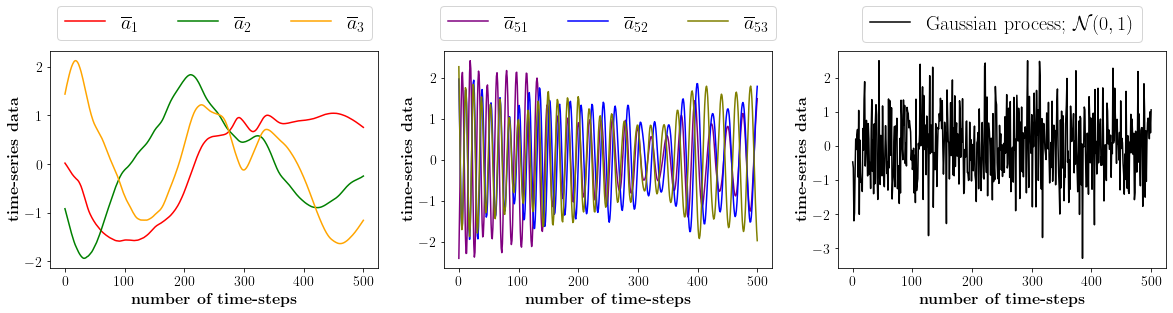

In [15]:
fig,axes = plt.subplots(1,3, figsize=(20, 4)) # 23,6

axes[0].plot(A_s[:,0], label=r'$\overline{a}_1$', color='red')
axes[0].plot(A_s[:,1], label=r'$\overline{a}_2$', color='green')
axes[0].plot(A_s[:,2], label=r'$\overline{a}_3$', color='orange')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

axes[1].plot(A_s[:,50], label=r'$\overline{a}_{51}$', color='purple')
axes[1].plot(A_s[:,51], label=r'$\overline{a}_{52}$', color='blue')
axes[1].plot(A_s[:,52], label=r'$\overline{a}_{53}$', color='olive')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

axes[2].plot(np.random.normal(size=A_s[:,0].size), label=r'Gaussian process; $\mathcal{N}(0,1)$', color='black')
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1)  # Move legend outside

for ax in axes:
    ax.set_ylabel(r'\bf{time-series data}')
    ax.set_xlabel(r'\bf{number of time-steps}')
# fig.suptitle(r'Time-series data corresponding to different EOFs')
plt.savefig('./plots/time_series_rescaled_time_measurement_t25_to_t45.pdf',bbox_inches='tight')

In [16]:
# calculating sample autocorrelation function
def acf(x,n_lags):
    '''manually compute, non partial'''

    mean = np.mean(x)
    var = np.var(x)
    xp = x - mean
    corr = [1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in np.arange(n_lags)]

    return np.array(corr)

In [17]:
n_lags = 200 # desired number of lags for ACF calculation

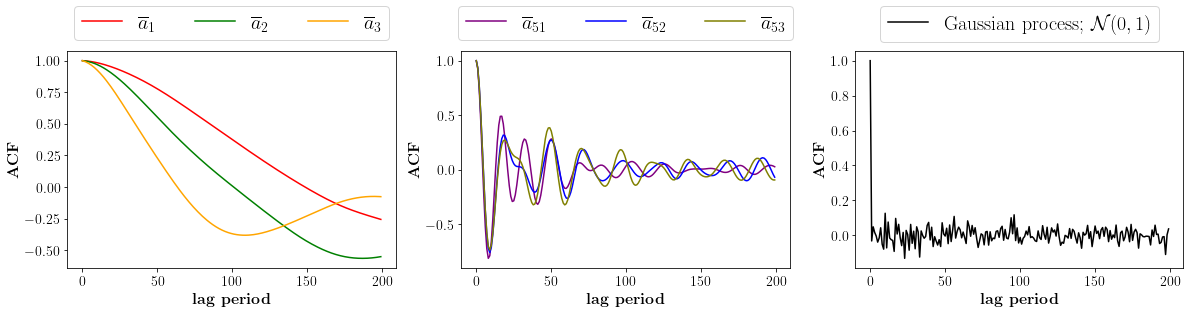

In [18]:
fig,axes = plt.subplots(1,3, figsize=(20, 4))

axes[0].plot(acf(A_s[:,0], n_lags), label=r'$\overline{a}_1$', color='red')
axes[0].plot(acf(A_s[:,1], n_lags), label=r'$\overline{a}_2$', color='green')
axes[0].plot(acf(A_s[:,2], n_lags), label=r'$\overline{a}_3$', color='orange')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

axes[1].plot(acf(A_s[:,50], n_lags), label=r'$\overline{a}_{51}$', color='purple')
axes[1].plot(acf(A_s[:,51], n_lags), label=r'$\overline{a}_{52}$', color='blue')
axes[1].plot(acf(A_s[:,52], n_lags), label=r'$\overline{a}_{53}$', color='olive')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

axes[2].plot(acf(np.random.normal(size=A_s[:,0].size), n_lags), label=r'Gaussian process; $\mathcal{N}(0,1)$', color='black')
axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1)  # Move legend outside

for ax in axes:
    ax.set_ylabel(r'\textbf{ACF}')
    ax.set_xlabel(r'\textbf{lag period}')
plt.savefig('./plots/acf_rescaled_time_measurement_t25_to_t45.pdf',bbox_inches='tight')

In [26]:
j = 33
print(acf(A_s[:,j], 2))

[1.         0.97218102]


In [27]:
# dicrete OU process/ autoregressive process, AR(1)
def auto_reg_1(x_arr, rand_input=False):
    '''x_arr: input array, returns simulated OU process'''
    phi = acf(x_arr, 2)[-1] # autocorrelation for lag 1
    sigma = np.sqrt(1 - phi**2) # std. dev. of additive noise
    y_arr = np.zeros(x_arr.size)
    if rand_input: # selecting the first element of sequence
        y_arr[0] = np.random.randn()
    else:
        y_arr[0] = x_arr[0]
    # generate OU process
    for i in range(x_arr.size-1):
        y_arr[i+1] = phi*y_arr[i] + sigma*np.random.randn()
    return y_arr

Text(0.5, 1.0, 'Realizations of autoregressive model, $\\phi =$0.999')

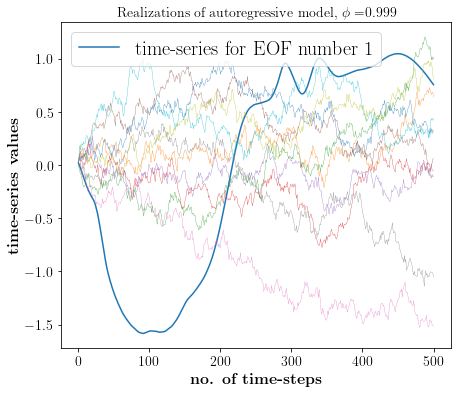

In [28]:
j = 0
n_particle = 10 # number of realization of OU process
fig,ax = plt.subplots( figsize=(7, 6))
a = A_s[:,j] # input time-series
phi = acf(a, 2)[-1]
ax.plot(a, label='time-series for EOF number '+str(j+1))
for i in range(n_particle):
    a_sim = auto_reg_1(a, rand_input=False)
    ax.plot(a_sim, linewidth=0.3)
    # ax.plot(a_sim, label='OU_sim'+str(i), linewidth=0.3)
ax.set_ylabel(r'\textbf{time-series values}')
ax.set_xlabel(r'\textbf{no. of time-steps}')
ax.legend()
plt.title(r'Realizations of autoregressive model, $\phi =$'+str(round(phi,3)))

Text(0.5, 1.0, 'Realizations of autoregressive model, $\\phi =$0.999')

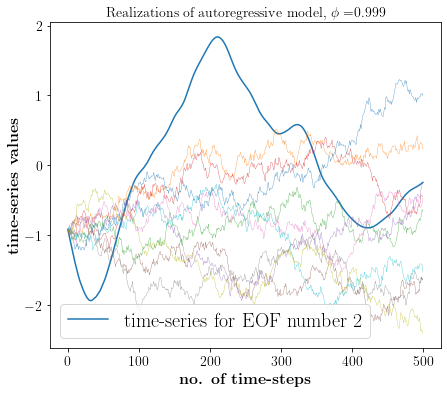

In [29]:
j = 1
n_particle = 10 # number of realization of OU process
fig,ax = plt.subplots( figsize=(7, 6))
a = A_s[:,j] # input time-series
phi = acf(a, 2)[-1]
ax.plot(a, label='time-series for EOF number '+str(j+1))
for i in range(n_particle):
    a_sim = auto_reg_1(a, rand_input=False)
    ax.plot(a_sim, linewidth=0.3)
    # ax.plot(a_sim, label='OU_sim'+str(i), linewidth=0.3)
ax.set_ylabel(r'\textbf{time-series values}')
ax.set_xlabel(r'\textbf{no. of time-steps}')
ax.legend()
plt.title(r'Realizations of autoregressive model, $\phi =$'+str(round(phi,3)))

Text(0.5, 1.0, 'Realizations of autoregressive model, $\\phi =$0.965')

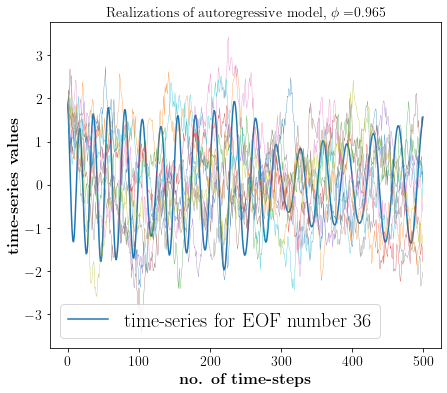

In [30]:
j = 35
n_particle = 10 # number of realization of OU process
fig,ax = plt.subplots( figsize=(7, 6))
a = A_s[:,j] # input time-series
phi = acf(a, 2)[-1]
ax.plot(a, label='time-series for EOF number '+str(j+1))
for i in range(n_particle):
    a_sim = auto_reg_1(a, rand_input=False)
    ax.plot(a_sim, linewidth=0.3)
    # ax.plot(a_sim, label='OU_sim'+str(i), linewidth=0.3)
ax.set_ylabel(r'\textbf{time-series values}')
ax.set_xlabel(r'\textbf{no. of time-steps}')
ax.legend()
plt.title(r'Realizations of autoregressive model, $\phi =$'+str(round(phi,3)))

Text(0.5, 1.0, 'Realizations of autoregressive model ')

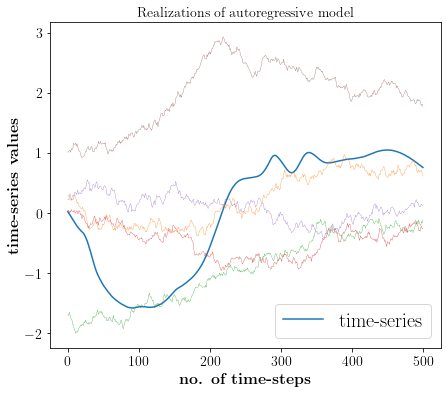

In [31]:
j = 0
n_particle = 5 # number of realization of OU process
fig,ax = plt.subplots(figsize=(7, 6))
a = A_s[:,j] # input time-series
ax.plot(a, label='time-series')
for i in range(n_particle):
    a_sim = auto_reg_1(a, rand_input=True)
    ax.plot(a_sim, linewidth=0.3)
    # ax.plot(a_sim, label='OU_sim'+str(i), linewidth=0.3)
ax.set_ylabel(r'\textbf{time-series values}')
ax.set_xlabel(r'\textbf{no. of time-steps}')
ax.legend()
plt.title(r'Realizations of autoregressive model ')

In order to implement this in code, i need only the ACF(1) values corresponding to all $\xi_i$.
I can store this information in an array and use them in the code (for SPDE simulation) later to generate the OU time-series.  

In [32]:
A_s.shape

(501, 501)

In [33]:
n_EOFs = 53 # we want to calculate ACF corresponding to time-series of n_EOFs xi's

In [34]:
acf_data = []
for i in range(n_EOFs):
    acf_data.append(acf(A_s[:,i], 2)[-1])

In [35]:
acf_data = np.array(acf_data).round(4)

In [36]:
print(acf_data)

[0.9993 0.9989 0.9962 0.9976 0.9979 0.9955 0.9957 0.9959 0.9941 0.9959
 0.9945 0.9923 0.9932 0.9939 0.9889 0.9924 0.9905 0.9869 0.9832 0.9817
 0.9842 0.9858 0.9845 0.979  0.9778 0.978  0.9765 0.9779 0.9777 0.9693
 0.9721 0.9677 0.9632 0.9722 0.9648 0.9648 0.9608 0.9618 0.9545 0.9566
 0.9635 0.9535 0.9572 0.9524 0.9476 0.9492 0.9509 0.9475 0.952  0.9268
 0.9232 0.9332 0.931 ]


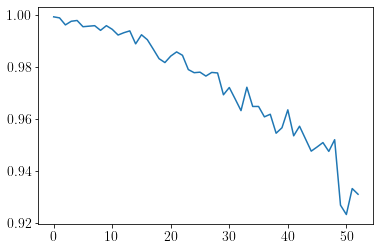

In [37]:
plt.plot(acf_data)

In [38]:
data_file = './acf_data/acf_1_data_53_EOFs_mesh_32_t25_to_t45_config1.npz'
np.savez(data_file, acf1_data = acf_data)

In [39]:
def OU_mat(n_tsteps, n_eofs, acf1_data):
    M = np.zeros((n_tsteps, n_eofs)) # matrix that stores the OU generated noise
    phi = acf1_data[:n_eofs] # autocorrelation for lag 1 array for n_eofs
    sigma = np.sqrt(1 - phi**2) # std. dev. of additive noise
    M[0,:] = np.random.normal(size=M[0,:].shape)
    for i in range(n_tsteps -1):
        M[i+1, :] = phi*M[i,:] + sigma*np.random.normal(size= sigma.shape)
    return M

In [40]:
M = OU_mat(500, 53, acf_data)

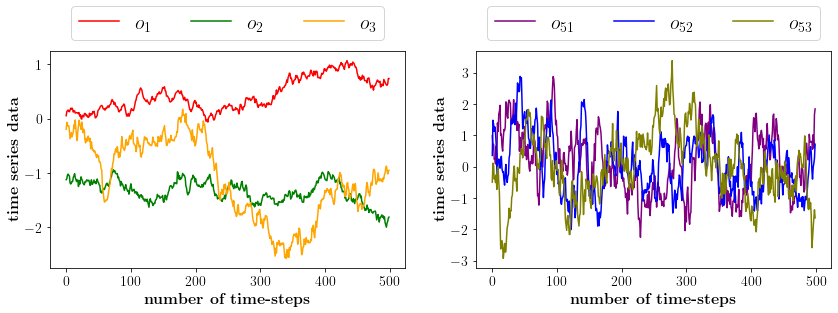

In [41]:
fig,axes = plt.subplots(1,2, figsize=(14, 4))
axes[0].plot(M[:,0], label=r'$o_1$', color='red')
axes[0].plot(M[:,1], label=r'$o_2$', color='green')
axes[0].plot(M[:,2], label=r'$o_3$', color='orange')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

axes[1].plot(M[:,50], label=r'$o_{51}$', color='purple')
axes[1].plot(M[:,51], label=r'$o_{52}$', color='blue')
axes[1].plot(M[:,52], label=r'$o_{53}$', color='olive')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)  # Move legend outside

for ax in axes:
    ax.set_ylabel(r'\textbf{time series data}')
    ax.set_xlabel(r'\textbf{number of time-steps}')
# plt.savefig('./plots/ou_generated_time_series.pdf',bbox_inches='tight')

In [42]:
np.var(M, axis=0)

array([0.08642626, 0.04248242, 0.52620286, 0.17943058, 0.2618631 ,
       0.37192098, 0.20351968, 0.21200346, 0.53831244, 0.16195832,
       0.47025077, 0.37184983, 0.30103926, 1.17809368, 0.45075189,
       0.57794529, 0.40909418, 1.05242605, 0.76939956, 1.24183145,
       0.65245445, 0.45651165, 0.61942781, 1.13449652, 0.92190783,
       0.62763938, 1.38768365, 1.11178979, 0.95830331, 0.95816578,
       1.20650279, 0.6239298 , 1.35731319, 0.7676043 , 0.55958788,
       0.9499704 , 0.84471433, 0.86296219, 0.54392461, 0.87180723,
       0.80371462, 0.58048783, 0.87433469, 0.74920478, 0.69564004,
       0.69952827, 0.63093554, 0.63416435, 0.71759365, 0.81038622,
       0.94934089, 0.85355353, 1.18739553])